In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer,AerSimulator

from qiskit_algorithms import AmplitudeEstimation

from qiskit_algorithms.optimizers import SLSQP
 
from qiskit.circuit.library import QFT
 

#Step 1
def load_stock_data(symbols, start_date, end_date):
    data = yf.download(symbols, start=start_date, end=end_date)
    returns = data['Adj Close'].pct_change().dropna()
    return returns

# Step 2: Classical
def portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    portfolio_return, portfolio_volatility = portfolio_performance(weights, mean_returns, cov_matrix)
    return -((portfolio_return - risk_free_rate) / portfolio_volatility)

def optimize_portfolio(returns):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets], args=args, 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Step 3: Quantum (incomplete)
def quantum_amplitude_estimation(mean_returns, cov_matrix):
    num_assets = len(mean_returns)

    
    circuit = QuantumCircuit(num_assets)
    circuit.h(range(num_assets))  

    
    simulator = Aer.get_backend('aer_simulator')
    transpiled_circuit = transpile(circuit, simulator)

     
    job = simulator.run(transpiled_circuit)
    result = job.result()

     
    quantum_weights = np.random.dirichlet(np.ones(num_assets), size=1).flatten()
    return quantum_weights



 


def compare_results(classical_result, quantum_weights, mean_returns, cov_matrix, asset_labels):
     
    classical_weights = classical_result.x
     
    classical_return, classical_volatility = portfolio_performance(classical_weights, mean_returns, cov_matrix)

     
    quantum_return, quantum_volatility = portfolio_performance(quantum_weights, mean_returns, cov_matrix)

     
    bar_width = 0.35
    index = np.arange(len(asset_labels))
# Step 4: Visualization of Results
    plt.bar(index, classical_weights, bar_width, label='Classical Optimization', alpha=0.7)
    plt.bar(index + bar_width, quantum_weights, bar_width, label='Quantum Estimation', alpha=0.7)

    plt.xlabel('Assets')
    plt.ylabel('Weights')
    plt.title('Portfolio Allocation Comparison')
    plt.xticks(index + bar_width / 2, asset_labels)
    plt.legend()
    plt.tight_layout()
    plt.show()


[*********************100%%**********************]  3 of 3 completed


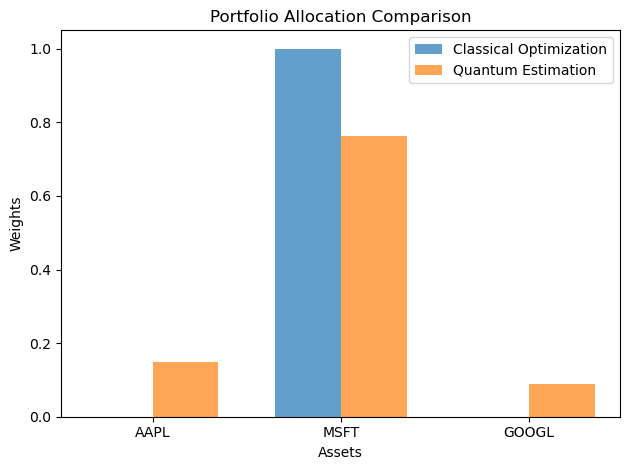

In [118]:

from datetime import datetime
symbols = ['AAPL', 'MSFT', 'GOOGL']  # Example stock symbols
start_date = '2023-06-24'
end_date = end_date = datetime.today().strftime('%Y-%m-%d')
stock_returns = load_stock_data(symbols, start_date, end_date)

 
classical_result = optimize_portfolio(stock_returns)

 
mean_returns = stock_returns.mean()
cov_matrix = stock_returns.cov()
quantum_weights = quantum_amplitude_estimation(mean_returns, cov_matrix)

 
compare_results(classical_result, quantum_weights, mean_returns, cov_matrix, symbols)
